# VELOX Processing Test Notebook

This notebook demonstrates loading a dataset, applying a quality mask, processing it with the pushbroom function, and visualizing the output.

Make sure your package is in the Python path or installed as a package so that you can import `pushbroom` from `velox_tools.processing`.

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

# Import the processing function from your package
from velox_tools.processing import pushbroom

ImportError: cannot import name 'pushbroom' from 'velox_tools.processing' (/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/velox_tools/processing.py)

## Load and Preprocess Dataset

Here we load a NetCDF dataset, sort it by time, and apply a quality mask based on the `BT_2D` variable. Only time steps where any data is present will be kept.

In [ ]:
# Load dataset and sort by time
ds = xr.open_dataset('../../../Mueller_et_al_2024/data/predicted/circles_georeff/RF12_hl06.nc').sortby('time')

# Create a quality mask from the first band of BT_2D: True if any non-null value exists in x and y
quality_mask = ds['BT_2D'].isel(band=0).notnull().any(dim=['x', 'y'])

# Select only the time steps where the quality mask is True
ds = ds.sel(time=quality_mask)

print('Dataset dimensions after applying quality mask:')
print(ds)

Dataset dimensions after applying quality mask:
<xarray.Dataset> Size: 12GB
Dimensions:       (time: 943, x: 635, y: 507, band: 5)
Coordinates:
  * time          (time) datetime64[ns] 8kB 2022-04-01T10:15:50 ... 2022-04-0...
  * x             (x) int64 5kB 0 1 2 3 4 5 6 7 ... 628 629 630 631 632 633 634
  * y             (y) int64 4kB 0 1 2 3 4 5 6 7 ... 500 501 502 503 504 505 506
Dimensions without coordinates: band
Data variables:
    lons          (time, x, y) float32 1GB ...
    lats          (time, x, y) float32 1GB ...
    skin_t        (time, x, y) float32 1GB ...
    surface_type  (time, x, y) int64 2GB ...
    BT_2D         (time, band, x, y) float32 6GB ...
Attributes:
    title:        Two dimensional surface type classification and surface tem...
    institution:  Leipzig University, Leipzig Institute for Meteorology
    contact_1:    joshua.mueller@uni-leipzig.de
    instrument:   VELOX
    campaign:     HALO-AC3
    created_on:   2024-11-16
    history:      2024-06-12: 

## Processing with the Pushbroom Function

Next, we process the dataset using the `pushbroom` function with a slicing position of 100 and specifying mode as `'xarray'`.

In [ ]:
# Process the dataset using the pushbroom function
cc = pushbroom(ds, mode='xarray', slicing_position=100)

print('Processed dataset dimensions:')
print(cc)

Executed concatenate_images3 in 3.5401 seconds
Processed dataset dimensions:
<xarray.Dataset> Size: 551MB
Dimensions:       (band: 5, y: 635, time: 21689)
Coordinates:
  * time          (time) datetime64[ns] 174kB 2022-04-01T10:15:50 ... 2022-04...
  * y             (y) int64 5kB 0 1 2 3 4 5 6 7 ... 628 629 630 631 632 633 634
Dimensions without coordinates: band
Data variables:
    BT_2D         (band, y, time) float32 275MB -17.72 -18.02 ... -24.12 -26.14
    lons          (y, time) float32 55MB 7.371 7.37 7.37 ... -1.968 -1.968
    lats          (y, time) float32 55MB 79.46 79.46 79.46 ... 80.13 80.13 80.13
    skin_t        (y, time) float32 55MB nan nan nan nan nan ... nan nan nan nan
    surface_type  (y, time) int64 110MB 3 3 3 3 3 3 3 3 3 ... 4 4 4 4 4 4 4 4 4


## Interpolate Missing Values

Now we interpolate missing values along the time dimension using the nearest method.

In [ ]:
# Interpolate missing values along time
cc2 = cc.interpolate_na(dim='time', method='nearest')

print('Dataset after interpolation:')
print(cc2)

Dataset after interpolation:
<xarray.Dataset> Size: 551MB
Dimensions:       (time: 21689, y: 635, band: 5)
Coordinates:
  * time          (time) datetime64[ns] 174kB 2022-04-01T10:15:50 ... 2022-04...
  * y             (y) int64 5kB 0 1 2 3 4 5 6 7 ... 628 629 630 631 632 633 634
Dimensions without coordinates: band
Data variables:
    BT_2D         (band, y, time) float32 275MB -17.72 -18.02 ... -24.12 -26.14
    lons          (y, time) float32 55MB 7.371 7.37 7.37 ... -1.968 -1.968
    lats          (y, time) float32 55MB 79.46 79.46 79.46 ... 80.13 80.13 80.13
    skin_t        (y, time) float32 55MB nan nan nan nan nan ... nan nan nan nan
    surface_type  (y, time) int64 110MB 3 3 3 3 3 3 3 3 3 ... 4 4 4 4 4 4 4 4 4


## Visualize the Result

Finally, we plot the first band of the processed `BT_2D` variable as an image. The `robust=True` flag is used for robust color scaling and the figure size is set to be wide and short.

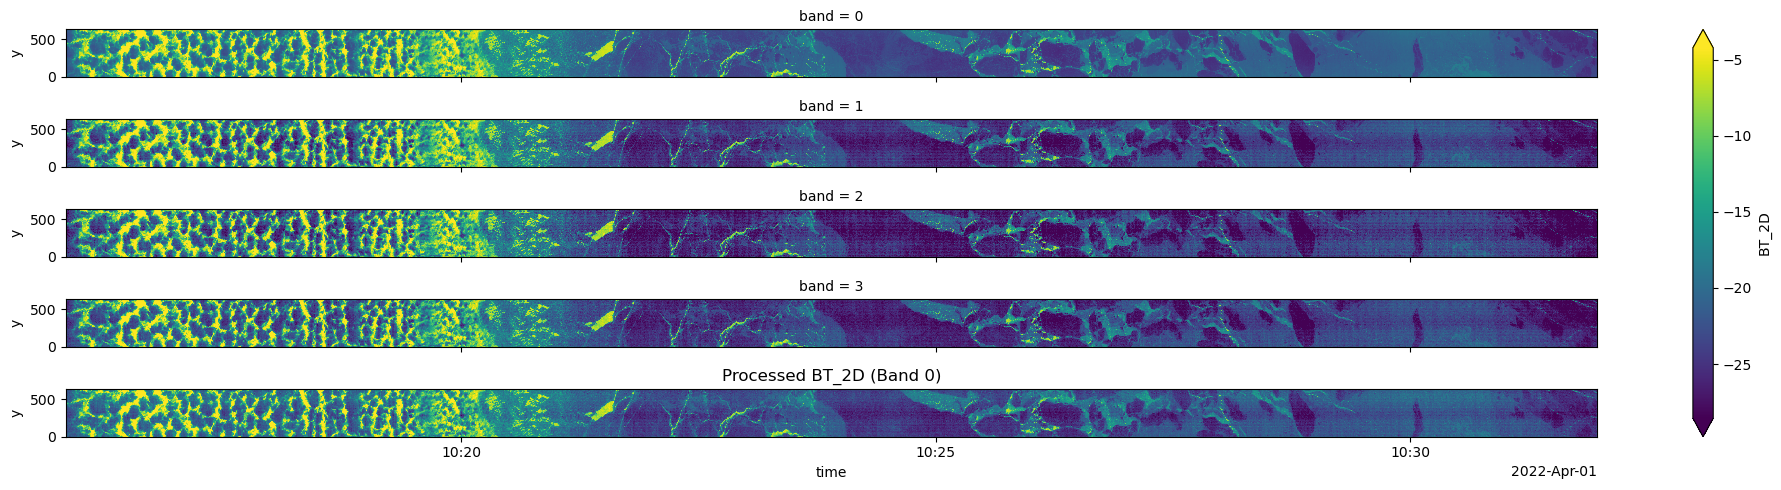

In [ ]:
# Plot the first band of BT_2D using imshow
cc2.BT_2D.plot.imshow(robust=True, figsize=(20, 5), col='band', col_wrap=1)
plt.title('Processed BT_2D (Band 0)')
plt.show()